In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [3]:
FOLDER = ''

da =      pd.read_csv(FOLDER + 'entsoe_da_prices.csv', index_col=0, parse_dates=True)['0']
gen =     pd.read_csv(FOLDER + 'entsoe_gen.csv', index_col=0, parse_dates=True)
demands = pd.read_csv(FOLDER + 'gb_demand.csv', index_col=0, parse_dates=True)['demand']
nbp =     pd.read_csv(FOLDER + 'nbp.csv', index_col=0).iloc[:, 0]
# NBP prices from: https://www.erce.energy/graph/uk-natural-gas-nbp-spot-price/
# Download the response from the request: https://www.erce.energy/simple-xlsx/readRawData.php

The marginal cost at time $t$ for generator $i$:

$cost_{t,i} = FOM_i + HR_i\cdot fuel_{t,i}$

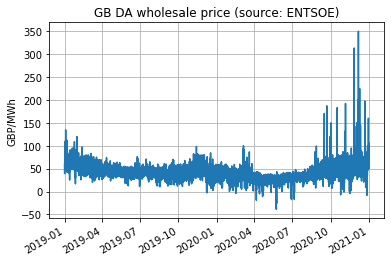

In [30]:
da.plot(title='GB DA wholesale price (source: ENTSOE)', grid=True);
plt.ylabel('GBP/MWh');

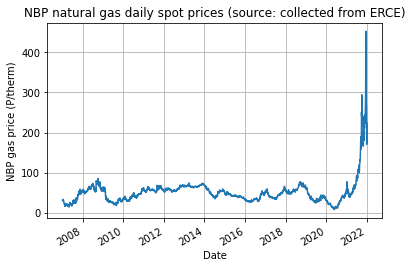

In [75]:
#https://www.erce.energy/graph/uk-natural-gas-nbp-spot-price/
nbp.index = pd.to_datetime(nbp.index)
nbp.plot(grid=True)
plt.title('NBP natural gas daily spot prices (source: collected from ERCE)')
plt.ylabel('NBP gas price (P/therm)');

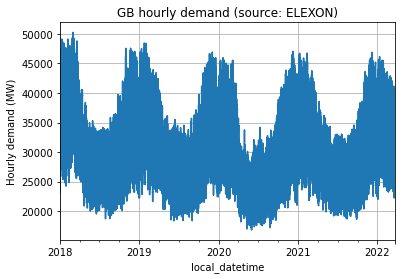

In [40]:
demands.plot(title='GB hourly demand (source: ELEXON)', grid=True)
plt.ylabel('Hourly demand (MW)');

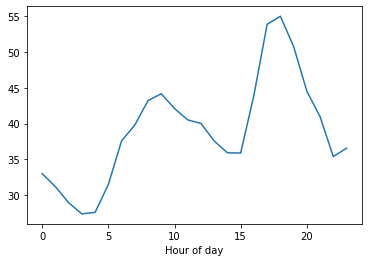

In [13]:
da.groupby(da.index.hour).mean().plot(); plt.xlabel('Hour of day');

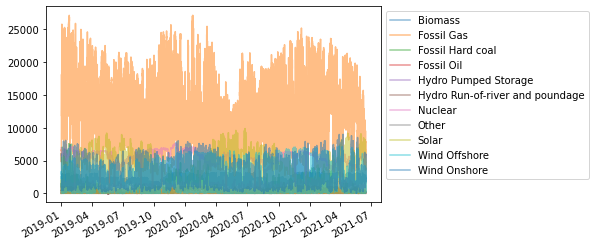

In [19]:
gen.plot(alpha=0.5); plt.legend(bbox_to_anchor=(1,1))

<AxesSubplot:>

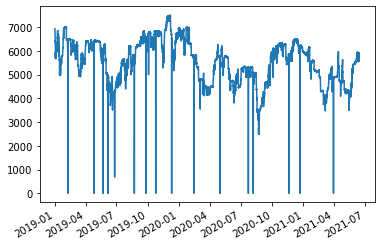

In [126]:
gen['Nuclear'].plot()

# Basic supply stack model

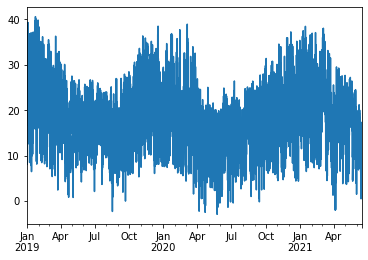

In [156]:
# SOLAR, WIND from forecasts; NUCLEAR can be forecasted based on outages etc.
netload = demands - gen[['Solar','Wind Offshore','Wind Onshore', 'Nuclear']].sum(1)
netload = netload.dropna().resample('H').mean() / 1000 # Convert to GWh units
netload.plot();

In [157]:
df = pd.DataFrame({
    'netload': netload,
    'netload2': netload**2,
    'netload3': netload**3,
    'netload4': netload**4,
    'NBP': nbp.resample('H').mean().fillna(method='ffill'),
    'da': da.groupby(level=0).mean()
}).dropna()
df['hour'] = df.index.hour

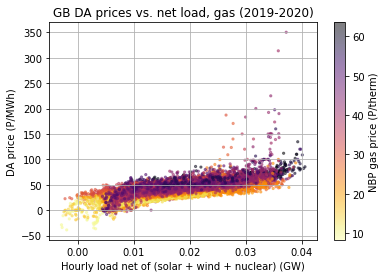

In [158]:
cm = plt.cm.get_cmap('inferno_r')

sc = plt.scatter(df['netload']/1000, df['da'], alpha=0.5, s=5, c=df['NBP'], cmap=cm); plt.grid(True)
plt.colorbar(sc, label='NBP gas price (P/therm)')
plt.xlabel('Hourly load net of (solar + wind + nuclear) (GW)')
plt.ylabel('DA price (P/MWh)');
plt.title('GB DA prices vs. net load, gas (2019-2020)');

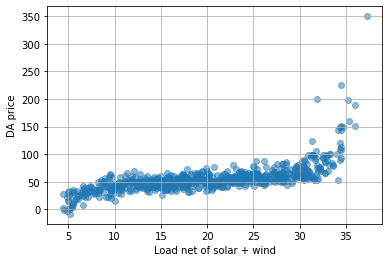

In [159]:
plt.scatter(df['netload'].tail(24*30), df['da'].tail(24*30), alpha=0.5); plt.grid(True)
plt.xlabel('Load net of solar + wind')
plt.ylabel('DA price');

In [160]:
m = smf.ols('da ~ netload*NBP + netload2 + netload3 + C(hour)*netload', df).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     da   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     827.0
Date:                Fri, 22 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:23:23   Log-Likelihood:                -61469.
No. Observations:               17517   AIC:                         1.230e+05
Df Residuals:                   17465   BIC:                         1.234e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -11.6984      1.166    -10.037      0.000     -13.983      -9.414
C(hour)[T.1]             -2.6958      1.411     -1.911      0.056      -5.461       0.069
C(hour)[T.2]             -5.5406      1.398     -3.963      0.000      -8.281      -2.800
C(hour)[T.3]             -7.1606      1.399     -5.119      0.000      -9.902      -4.419
C(hour)[T.4]             -6.3808      1.402     -4.550      0.000      -9.129      -3.632
C(hour)[T.5]             -5.5479      1.405     -3.950      0.000      -8.301      -2.795
C(hour)[T.6]             -5.2211      1.404     -3.718      0.000      -7.974      -2.468
C(hour)[T.7]             -3.2258      1.385     -2.330      0.020      -5.940      -0.512
C(hour)[T.8]              5.6443      1.368      4.125      0.000       2.962       8.326
C(hour)[T.9]             12.2177      1.326      9.217      0.000       9.619      14.816
C(hour)[T.10]            14.4649      1.275     11.348      0.000      11.967      16.963
C(hour)[T.11]            14.5507      1.248     11.655      0.000      12.104      16.998
C(hour)[T.12]            16.0326      1.222     13.118      0.000      13.637      18.428
C(hour)[T.13]            12.5570      1.214     10.343      0.000      10.177      14.937
C(hour)[T.14]             8.6982      1.225      7.101      0.000       6.297      11.099
C(hour)[T.15]             4.5610      1.282      3.558      0.000       2.048       7.074
C(hour)[T.16]             1.4922      1.382      1.080      0.280      -1.216       4.200
C(hour)[T.17]            -2.1507      1.480     -1.453      0.146      -5.052       0.750
C(hour)[T.18]            12.5467      1.564      8.023      0.000       9.482      15.612
C(hour)[T.19]            17.9192      1.626     11.019      0.000      14.732      21.107
C(hour)[T.20]            17.7047      1.630     10.859      0.000      14.509      20.900
C(hour)[T.21]            13.0743      1.572      8.317      0.000       9.993      16.156
C(hour)[T.22]             7.2345      1.455      4.973      0.000       4.383      10.086
C(hour)[T.23]             5.8028      1.408      4.122      0.000       3.043       8.562
netload                   4.2453      0.122     34.662      0.000       4.005       4.485
C(hour)[T.1]:netload      0.0916      0.106      0.867      0.386      -0.115       0.299
C(hour)[T.2]:netload      0.1649      0.106      1.561      0.119      -0.042       0.372
C(hour)[T.3]:netload      0.2027      0.107      1.894      0.058      -0.007       0.413
C(hour)[T.4]:netload      0.1468      0.107      1.373      0.170      -0.063       0.356
C(hour)[T.5]:netload      0.2297      0.101      2.275      0.023       0.032       0.428
C(hour)[T.6]:netload      0.3595      0.093      3.854      0.000       0.177       0.542
C(hour)[T.7]:netload   

In [161]:
m = smf.ols('da ~ netload*NBP + netload2 + netload3 + C(hour)*netload', df.tail(24*30)).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     da   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     50.35
Date:                Fri, 22 Apr 2022   Prob (F-statistic):          2.70e-194
Time:                        09:23:29   Log-Likelihood:                -2762.8
No. Observations:                 720   AIC:                             5630.
Df Residuals:                     668   BIC:                             5868.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -132.5820     20.013     -6.625      0.000    -171.879     -93.285
C(hour)[T.1]              0.6439      9.075      0.071      0.943     -17.175      18.463
C(hour)[T.2]             -1.1772      9.169     -0.128      0.898     -19.181      16.826
C(hour)[T.3]             -1.0447      9.302     -0.112      0.911     -19.310      17.220
C(hour)[T.4]              1.9209      9.082      0.212      0.833     -15.913      19.754
C(hour)[T.5]             -9.8258      9.325     -1.054      0.292     -28.136       8.484
C(hour)[T.6]            -11.6373      9.238     -1.260      0.208     -29.775       6.501
C(hour)[T.7]            -14.3207      9.334     -1.534      0.125     -32.649       4.007
C(hour)[T.8]            -11.5363     10.202     -1.131      0.259     -31.567       8.495
C(hour)[T.9]             -3.0877     10.596     -0.291      0.771     -23.893      17.718
C(hour)[T.10]             6.8973     10.873      0.634      0.526     -14.452      28.247
C(hour)[T.11]            -0.9210     10.295     -0.089      0.929     -21.136      19.294
C(hour)[T.12]             9.8330     10.699      0.919      0.358     -11.174      30.840
C(hour)[T.13]            11.8463     10.941      1.083      0.279      -9.637      33.330
C(hour)[T.14]             2.7541     10.958      0.251      0.802     -18.762      24.270
C(hour)[T.15]             2.5100     12.598      0.199      0.842     -22.227      27.247
C(hour)[T.16]            -0.4652     12.991     -0.036      0.971     -25.973      25.043
C(hour)[T.17]           -54.0823     13.360     -4.048      0.000     -80.316     -27.849
C(hour)[T.18]            10.6066     12.765      0.831      0.406     -14.457      35.670
C(hour)[T.19]            19.6194     11.957      1.641      0.101      -3.858      43.096
C(hour)[T.20]             4.9925     11.423      0.437      0.662     -17.437      27.422
C(hour)[T.21]            -0.6082     10.407     -0.058      0.953     -21.043      19.826
C(hour)[T.22]             2.3136      9.592      0.241      0.809     -16.521      21.148
C(hour)[T.23]             7.1301      9.088      0.785      0.433     -10.714      24.974
netload                  19.9967      1.455     13.745      0.000      17.140      22.853
C(hour)[T.1]:netload     -0.1338      0.649     -0.206      0.837      -1.407       1.140
C(hour)[T.2]:netload     -0.3291      0.663     -0.496      0.620      -1.631       0.973
C(hour)[T.3]:netload     -0.5848      0.690     -0.847      0.397      -1.940       0.771
C(hour)[T.4]:netload     -0.8261      0.686     -1.205      0.229      -2.173       0.520
C(hour)[T.5]:netload      0.3190      0.682      0.468      0.640      -1.021       1.659
C(hour)[T.6]:netload      0.7796      0.604      1.291      0.197      -0.406       1.966
C(hour)[T.7]:netload   